# Assignment Day 3

## Part 1

Student: José Maria Trindade

Master: Master in Big Data and AI solutions

We are the lead data scientist of SmartInvestment.com. Our company sells investment funds tailored to maximise results and minimise risk. An investment fund is just a basket of investment products. Our star fund is called FAANG+_forever.

The fund composition is the following:

- 15% Facebook (Meta). Symbol META
- 10% Netflix. Symbol NFLX
- 25% Apple. Symbol APPL
- 15% Tesla. Symbol TSLA
- 20% Google (Alphabet). Symbol GOOGL
- 15% Amazon. Symbol AAMZ


Clarification: gain/loss for a particular period is the difference of the close price of that period minus the close price of the previous period.

In [1]:
# Import section

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Assingning the current working directory to a variable

path_to_folder = os.getcwd()

## Exercises

#### 1. For regulatory reasons we need to provide to our investors a quarter by quarter report with the proformance of the fund  (% increased or lost, in that case the % will be negative) comparing it with the performance of the SPX500.

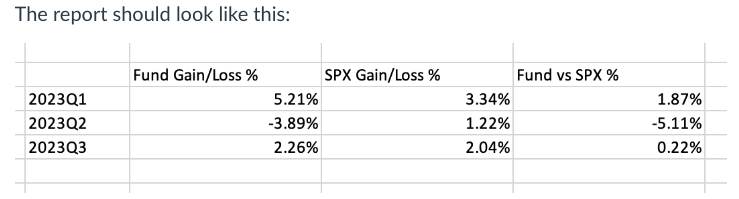

#### Reasoning to answer this question:  

The data needed to compute this table is spread across multiple csv files.
Every asset has 2 csv files. Together they form a time window fom 2022/12/01 - 2023/10/26.

We will filter for the last day of each quarter, and focus on the Close price column.

To get to the quarter performance of the fund, we need to get the quarter performance of each asset that forms the fund. After that, we create a full series of the fund performance with a weighted average of each asset.

The quarter performance of the spx is calculated the same way as for the assets.

I will use 2 functions to automate repeated steps.

In [3]:
# End of each Quarter Dates to filter for

end_2022Q4 = "2022-12-30"
end_2023Q1 = "2023-03-31"
end_2023Q2 = "2023-06-30"
end_2023Q3 = "2023-09-29"

In [4]:
# Function that gives you a dataframe based on the csv files of each asset

def get_df(symbol,path_to_folder):
    
    # I'll drop the last column stock splits as it only contains null values and it's not relevant to this assignment
    # Also, the stock information is contained into seperate files. We need to import and concatenate the info
        
        df1=pd.read_csv("{}/{}_1.csv".format(path_to_folder,symbol),\
                        usecols=[0,1,2,3,4,5,6]
                       )
        
        df2=pd.read_csv("{}/{}_2.csv".format(path_to_folder,symbol),\
                        usecols=[0,1,2,3,4,5,6]
                       )
        
        frames = [df2,df1]
        df = pd.concat(frames)
        
        # The time zone is not relevant to our assignment, and therefore we will only need format = "%Y-%m-%d"
        df["Date"] = df["Date"].apply(lambda row: row[:10])
        
        #Building a datetime index dataframe
        df = df.set_index('Date')
        df.index = pd.to_datetime(df.index,format = "%Y-%m-%d")
        
        return df    

In [5]:
# Function that gives you a series of the quarter performance of a given asset

def quarter_performance(df):
        
    Q1 = ((df["Close"].loc[end_2023Q1] / df["Close"].loc[end_2022Q4]) - 1) * 100

    Q2 = ((df["Close"].loc[end_2023Q2] / df["Close"].loc[end_2023Q1]) - 1) * 100

    Q3 = ((df["Close"].loc[end_2023Q3] / df["Close"].loc[end_2023Q2]) - 1) * 100

    return pd.Series(data=[Q1,Q2,Q3])  

In [6]:
# Getting a dataframe for every asset of our study

facebook = get_df('META',path_to_folder)
netflix = get_df('NFLX',path_to_folder)
apple = get_df('AAPL',path_to_folder)
tesla = get_df('TSLA',path_to_folder)
google = get_df('GOOGL',path_to_folder)
amazon = get_df('AMZN',path_to_folder)

spx = get_df('SPX',path_to_folder)

In [16]:
# Let's create a pandas df ("table") desired as the output where each column is the quarter performance of a stock

table = pd.DataFrame()
table["facebook"] = quarter_performance(facebook)
table["netflix"] = quarter_performance(netflix)
table["apple"] = quarter_performance(apple)
table["tesla"] = quarter_performance(tesla)
table["google"] = quarter_performance(google)
table["amazon"] = quarter_performance(amazon)

# New column for the fund which is a weighted combination of the previous ones
table["Fund Gain/Loss %"] = table["facebook"]*0.15 + table["netflix"]*0.1\
                            + table["apple"]*0.25 + table["tesla"]*0.15\
                            + table["google"]*0.20 + table["amazon"]*0.15

# New colum for the SPX
table["SPX Gain/Loss %"] = quarter_performance(spx)

# Comparison between the performance of the fund vs spx
table["Fund vs SPX %"] = table["Fund Gain/Loss %"] - table["SPX Gain/Loss %"]

# Renaming the index
table.index = ["2023Q1","2023Q2","2023Q3"]

In [17]:
# ANSWER
table[["Fund Gain/Loss %","SPX Gain/Loss %","Fund vs SPX %"]].round(2).astype(str)+"%"

,Fund Gain/Loss %,SPX Gain/Loss %,Fund vs SPX %
2023Q1,37.13%,7.03%,30.1%
2023Q2,23.45%,8.3%,15.15%
2023Q3,-2.81%,-3.65%,0.84%


### 2. We also want to provide visual and more short term information to our customers so we want to provide the following 2 charts:
For the charts include all data in the files excluding the first and the last week as they are not complete.

#### A) Line chart with weekly gain/loss % of the fund and SPX (both in the same chart)

In [8]:
# Function that gives you a df with the weekly performance of a given asset

def weekly_performance(df):
    
    #Let's filter our df for Fridays
    df1 = df[df.index.dayofweek == 4][["Close"]]
    
    #There is a holiday on the 7th of April 2023, meaning there is no data avaoçanle.
    #As such, we will use the data of the day before = 6th of April
    df2 = df[df.index == "2023-04-06"]

    #Concatenating the 2 dateframes and sorting the index
    df = df = pd.concat([df1,df2]).sort_index()
    
    #Creating a new column called Performance that is the grow rate of the close price from the last business day of the week
    
    df["Performance"] = ((df["Close"]/df["Close"].shift(1))-1)*100
    df = df.drop("2022-12-02")
    
    
    return df["Performance"]  

In [22]:
# Let's create a pandas df (table) desired as the output where each column is the weekly performance of a asset

table = pd.DataFrame()
table["facebook"] = weekly_performance(facebook)
table["netflix"] = weekly_performance(netflix)
table["apple"] = weekly_performance(apple)
table["tesla"] = weekly_performance(tesla)
table["google"] = weekly_performance(google)
table["amazon"] = weekly_performance(amazon)

# New column for the fund which is a combination of the previous ones
table["Fund Gain/Loss %"] = table["facebook"]*0.15 + table["netflix"]*0.1\
                            + table["apple"]*0.25 + table["tesla"]*0.15\
                            + table["google"]*0.20 + table["amazon"]*0.15

# New colum for the SPX
table["SPX Gain/Loss %"] = weekly_performance(spx)


# Getting the relevant df to plot
df = table[["Fund Gain/Loss %","SPX Gain/Loss %"]].round(2)


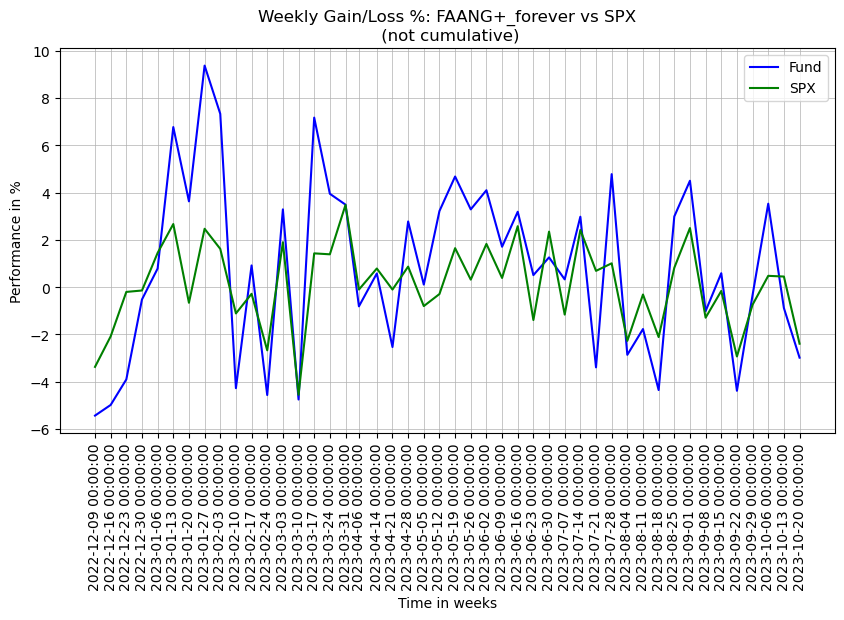

In [23]:
# Creating the Line chart
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_title("Weekly Gain/Loss %: FAANG+_forever vs SPX\n (not cumulative)")
ax.set_xlabel("Time in weeks")
ax.set_ylabel("Performance in %")

ax.plot(df.index, df["Fund Gain/Loss %"], label="Fund", color="blue")
ax.plot(df.index, df["SPX Gain/Loss %"], label="SPX", color="green")

ax.set_xticks(df.index)
ax.set_xticklabels(df.index, rotation=90)

ax.grid(True, linestyle='-', linewidth=0.5)

ax.legend()
plt.show()

#### B) Line chart with weekly acummulated gain/loss % of the fund and SPX (both in the same chart) 

In [24]:
# Let's create 2 extra columns for the Cumulative performance of the fund and SPX.
df["Cumulative Fund Gain/Loss %"] = df["Fund Gain/Loss %"].cumsum()
df["Cumulative SPX Gain/Loss %"] = df["SPX Gain/Loss %"].cumsum()

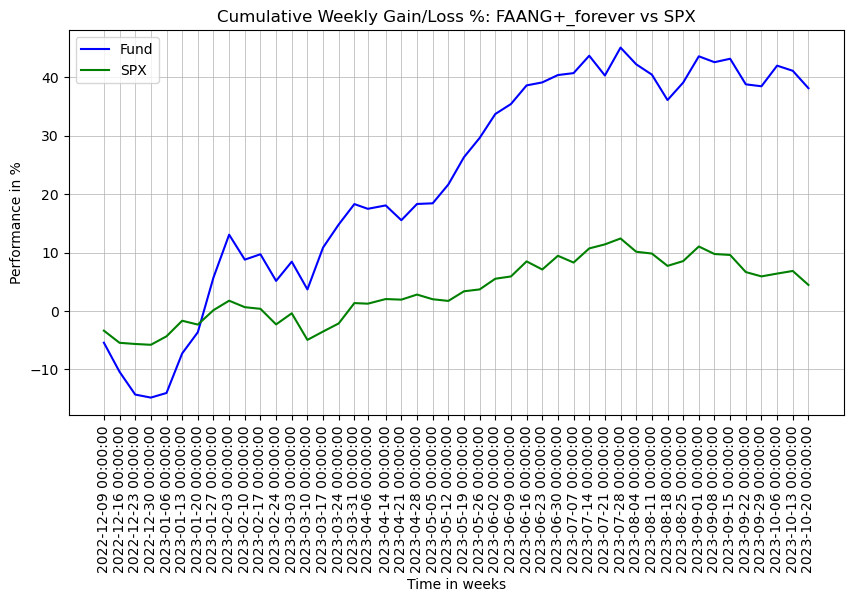

In [25]:
# Creating the Line chart for the weekly acummulated gain/loss %
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_title("Cumulative Weekly Gain/Loss %: FAANG+_forever vs SPX")
ax.set_xlabel("Time in weeks")
ax.set_ylabel("Performance in %")

ax.plot(df.index, df["Cumulative Fund Gain/Loss %"], label="Fund", color="blue")
ax.plot(df.index, df["Cumulative SPX Gain/Loss %"], label="SPX", color="green")

ax.set_xticks(df.index)
ax.set_xticklabels(df.index, rotation=90)

ax.grid(True, linestyle='-', linewidth=0.5)

ax.legend()
plt.show()